In [1]:
import orbit
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.backtest import BackTester
from orbit.diagnostics.metrics import mae, mse, smape, wmape

import pandas as pd
import pandahouse as ph
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

In [2]:
# Это мы в Clickhouse ходить будем
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250220'
}

In [3]:
query = '''
SELECT 
    toDate(time) date,
    count(action) as actions,
    uniqExact(user_id) as dau,
    uniqExact(post_id) as posts
FROM 
    simulator_20250220.feed_actions
GROUP BY date
HAVING date between min(date) and max(date)
ORDER BY date
'''
df = ph.read_clickhouse(query, connection=connection)
df.head()

,date,actions,dau,posts
0,2025-01-04,9163,878,89
1,2025-01-05,75586,2238,178
2,2025-01-06,126484,3105,191
3,2025-01-07,142796,3721,211
4,2025-01-08,208958,4617,214


In [4]:
#проверяем размер
df.shape

(79, 4)

In [5]:
#возьмем еще сообщения и добавим их к основному датасету
query_2 = '''
SELECT 
        toDate(time) date,
        count(user_id) messages
FROM 
    simulator_20250220.message_actions
GROUP BY date
HAVING date between min(date) and max(date)
ORDER BY date
'''
df_2 = ph.read_clickhouse(query_2, connection=connection)
df_2.head()

,date,messages
0,2025-01-04,3226
1,2025-01-05,12895
2,2025-01-06,12897
3,2025-01-07,12897
4,2025-01-08,12898


In [6]:
df['messages'] = df_2['messages']

In [7]:
df.head()

,date,actions,dau,posts,messages
0,2025-01-04,9163,878,89,3226
1,2025-01-05,75586,2238,178,12895
2,2025-01-06,126484,3105,191,12897
3,2025-01-07,142796,3721,211,12897
4,2025-01-08,208958,4617,214,12898


In [8]:
#собираем все активитис

df['all_activities'] = df['messages'] + df['actions'] + df['posts']

In [9]:
df=df.reset_index()

In [10]:
df.head()

,index,date,actions,dau,posts,messages,all_activities
0,0,2025-01-04,9163,878,89,3226,12478
1,1,2025-01-05,75586,2238,178,12895,88659
2,2,2025-01-06,126484,3105,191,12897,139572
3,3,2025-01-07,142796,3721,211,12897,155904
4,4,2025-01-08,208958,4617,214,12898,222070


<Axes: xlabel='date', ylabel='all_activities'>

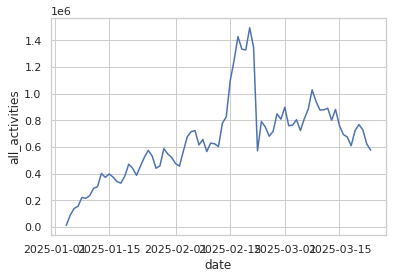

In [11]:
#смотрим их распределение
sns.lineplot(data=df, x="date", y="all_activities")

<Axes: xlabel='date', ylabel='dau'>

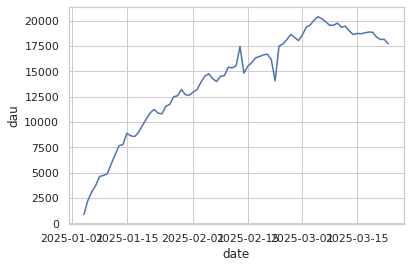

In [12]:
#смотрим распределение dau
sns.lineplot(data=df, x="date", y="dau")

Вроде все ок, опишем модели

## Строим модели

1. Обычная модель с линейным трендом
2. Обычная модель с логлинейным трендом
3. Линейный тренд + DAU как регрессор
4. Логлинейный тренд + DAU как регрессор
5. Линейный тренд + DAU + аномалия
6. Логлинейный тренд + DAU + аномалия

In [14]:
#Добавим в наш датасет колонку с аномалией в момент когда у нас проходил флешмоб, чтобы методы работали корректно

df["anomaly"] = np.where((df.date >= "2025-02-14") & (df.date <= "2025-02-20"), 1, 0)
df.head()

,index,date,actions,dau,posts,messages,all_activities,anomaly
0,0,2025-01-04,9163,878,89,3226,12478,0
1,1,2025-01-05,75586,2238,178,12895,88659,0
2,2,2025-01-06,126484,3105,191,12897,139572,0
3,3,2025-01-07,142796,3721,211,12897,155904,0
4,4,2025-01-08,208958,4617,214,12898,222070,0


In [15]:
act_mean = df.all_activities.mean()
act_sd = df.all_activities.std()

dau_mean = df.dau.mean()
dau_sd = df.dau.std()

df["DAU_stand"] = (df.dau - dau_mean) / dau_sd
df["act_stand"] = (df.all_activities - act_mean) / act_sd

In [16]:
simple_lin = DLT(response_col="act_stand", 
                 date_col="date", 
                 estimator="stan-mcmc", 
                 global_trend_option="linear",
                 num_warmup=10000,
                 num_sample=10000)

simple_loglin = DLT(response_col="act_stand", 
                 date_col="date", 
                 estimator="stan-mcmc", 
                 global_trend_option="loglinear",
                 num_warmup=10000,
                 num_sample=10000)

dau_lin = DLT(response_col="act_stand", 
            date_col="date", 
            estimator="stan-mcmc", 
            global_trend_option="linear", 
            regressor_col=["DAU_stand"], regressor_sign=["+"], 
            num_warmup=10000,
            num_sample=10000)

dau_loglin = DLT(response_col="act_stand", 
               date_col="date", 
               estimator="stan-mcmc", 
               global_trend_option="loglinear",
               regressor_col=["DAU_stand"], regressor_sign=["+"], 
               num_warmup=10000,
               num_sample=10000)

anom_lin = DLT(response_col="act_stand", 
            date_col="date", 
            estimator="stan-mcmc", 
            global_trend_option="linear", 
            regressor_col=["DAU_stand", "anomaly"], regressor_sign=["+", "+"], 
            num_warmup=10000,
            num_sample=10000)

anom_loglin = DLT(response_col="act_stand", 
               date_col="date", 
               estimator="stan-mcmc", 
               global_trend_option="loglinear",
               regressor_col=["DAU_stand", "anomaly"], regressor_sign=["+", "+"], 
               num_warmup=10000,
               num_sample=10000)

In [17]:
#положим в список

model_list = [simple_lin, simple_loglin, dau_lin, dau_loglin, anom_lin, anom_loglin]

In [18]:
#обучаем

for model in model_list:
    
    model.fit(df)

2025-03-23 17:58:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.
2025-03-23 17:58:15 - orbit - INFO - First time in running stan model:dlt. Expect 3 - 5 minutes for compilation.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 17:59:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 17:59:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 17:59:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 17:59:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 17:59:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [19]:
futur = model_list[0].make_future_df(periods=30)

In [20]:
pred_1 = model_list[0].predict(futur)
pred_2 = model_list[1].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

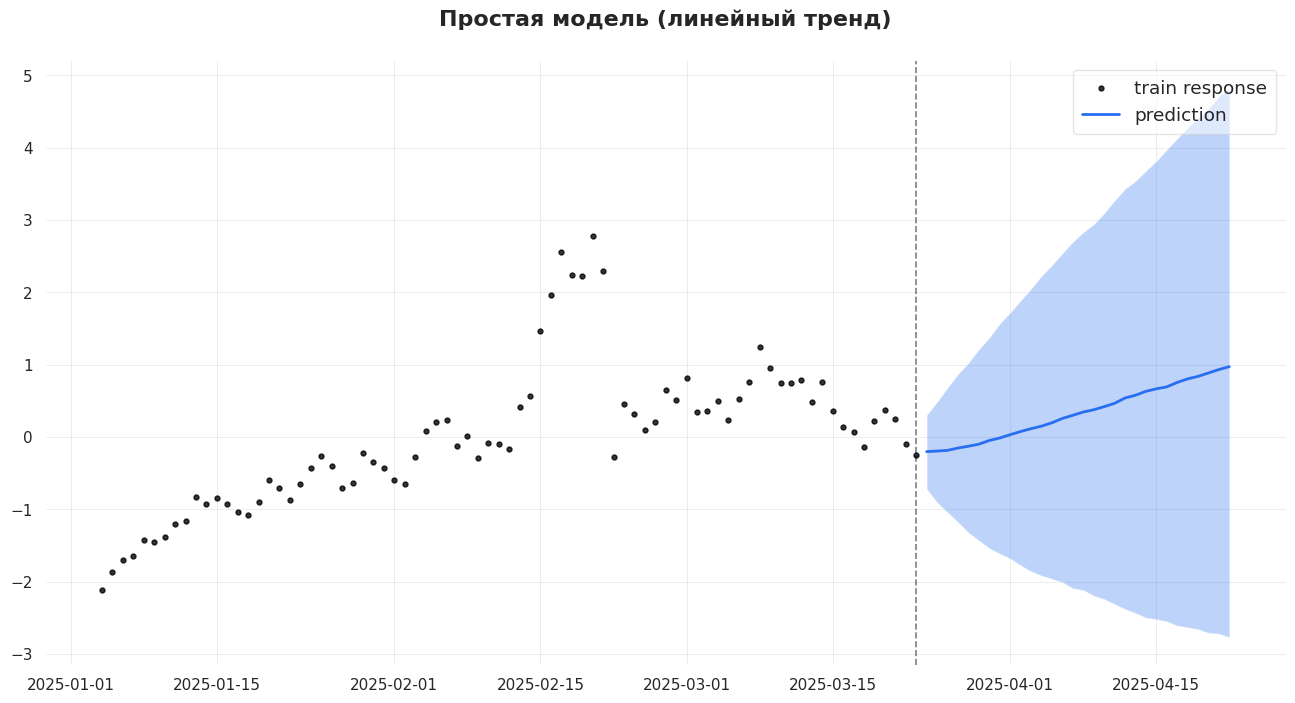

In [21]:
_ = plot_predicted_data(df, pred_1, "date", 'act_stand', title='Простая модель (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

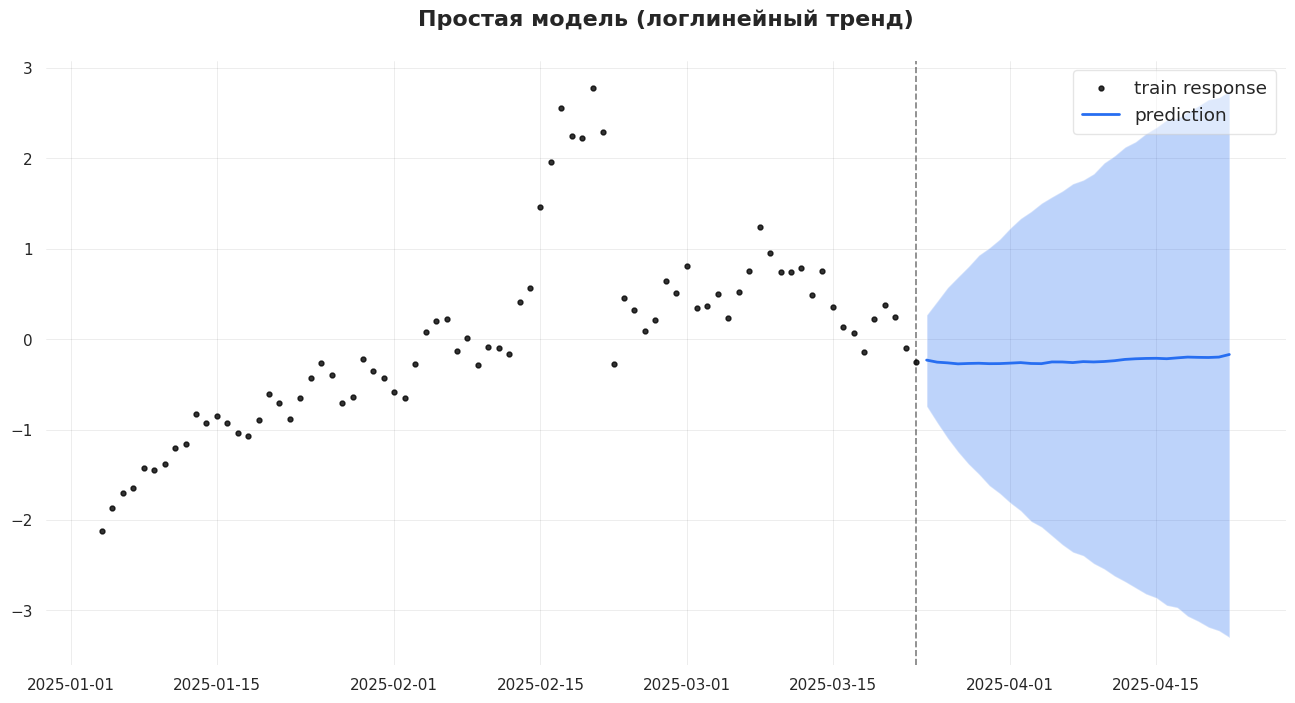

In [22]:
_ = plot_predicted_data(df, pred_2, "date", 'act_stand', title='Простая модель (логлинейный тренд)')

In [23]:
dau_model = DLT(response_col="DAU_stand", 
                 date_col="date", 
                 estimator="stan-mcmc", 
                 global_trend_option="linear",
                 num_warmup=10000,
                 num_sample=10000)

dau_model.fit(df)
dau_pred = dau_model.predict(futur)

2025-03-23 17:59:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

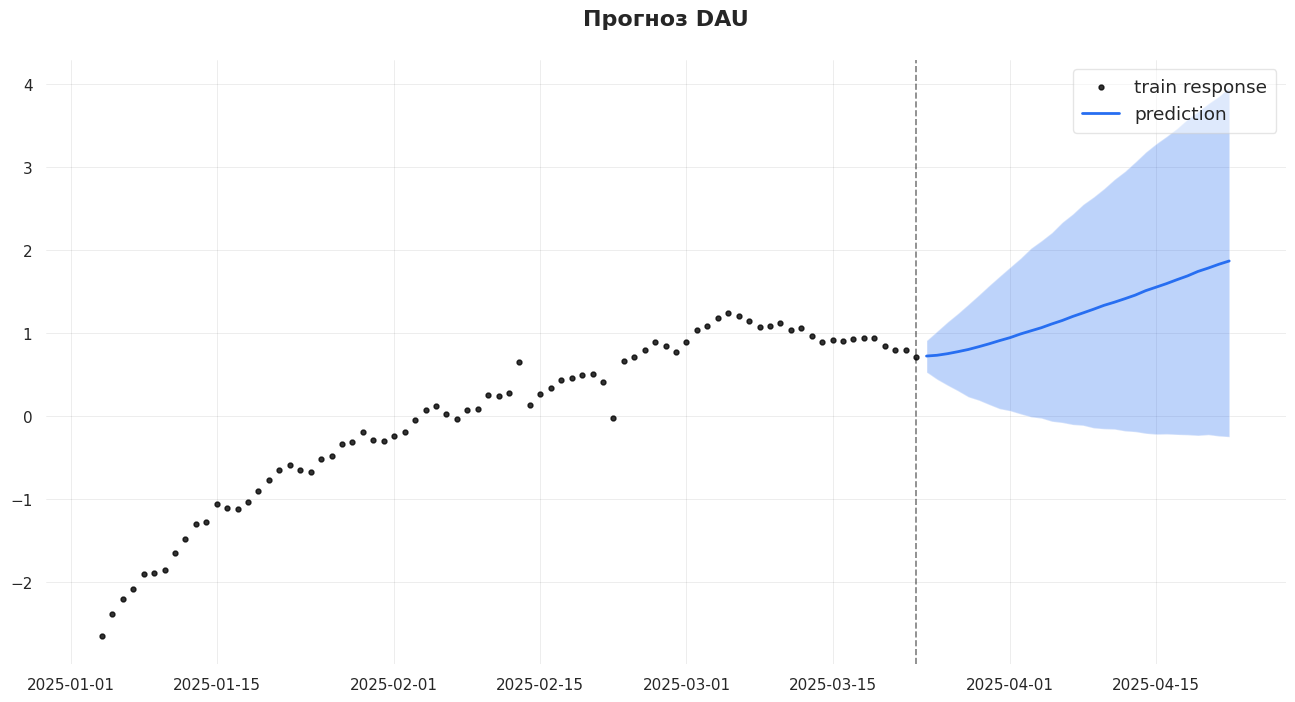

In [24]:
_ = plot_predicted_data(df, dau_pred, "date", 'DAU_stand', title='Прогноз DAU')

In [25]:
futur["DAU_stand"] = dau_pred.prediction
futur.head()

,date,DAU_stand
0,2025-03-24,0.721276
1,2025-03-25,0.730488
2,2025-03-26,0.749365
3,2025-03-27,0.773625
4,2025-03-28,0.800190


In [26]:
model_list[2].get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,DAU_stand,Positive,0.821284,0.347824,1.291025,1.0,0.0


In [27]:
pred_3 = model_list[2].predict(futur)
pred_4 = model_list[3].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

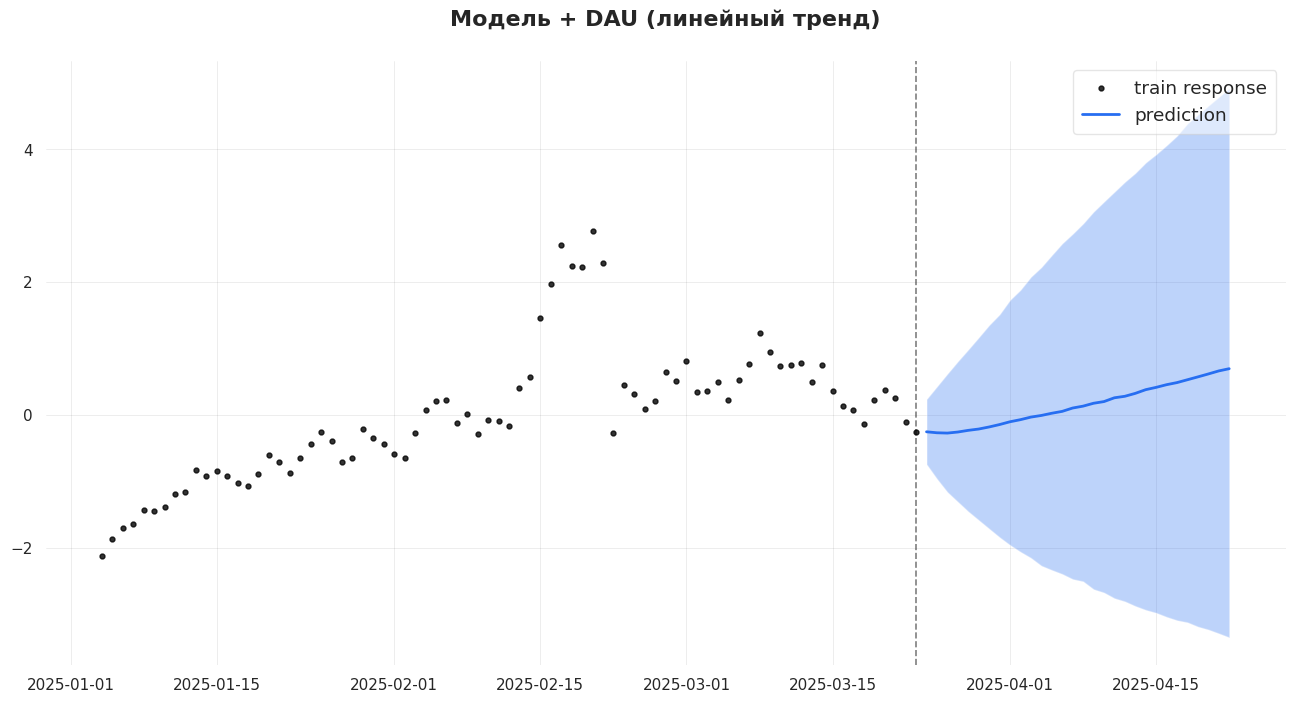

In [28]:
_ = plot_predicted_data(df, pred_3, "date", 'act_stand', title='Модель + DAU (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

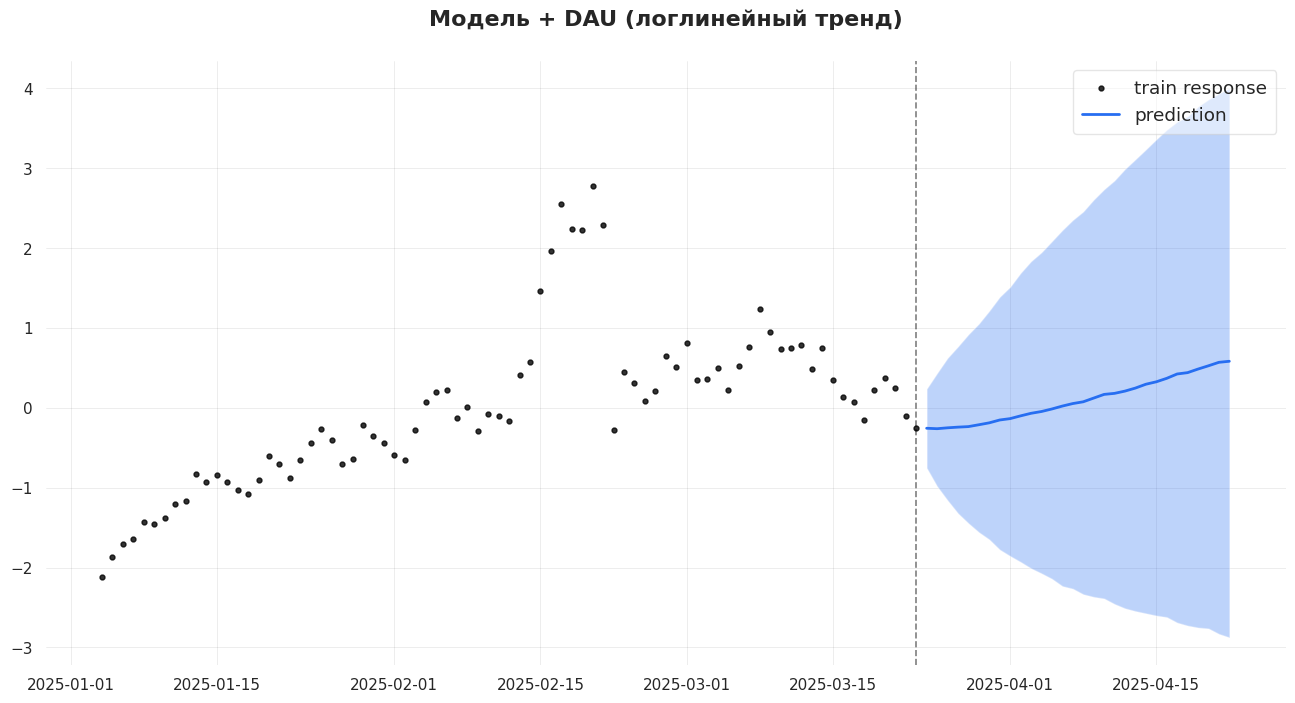

In [29]:
_ = plot_predicted_data(df, pred_4, "date", 'act_stand', title='Модель + DAU (логлинейный тренд)')

Добавим столбец с анамолией в будущий датасет

In [30]:
futur["anomaly"] = 0
futur.head()

,date,DAU_stand,anomaly
0,2025-03-24,0.721276,0
1,2025-03-25,0.730488,0
2,2025-03-26,0.749365,0
3,2025-03-27,0.773625,0
4,2025-03-28,0.800190,0


In [31]:
pred_5 = model_list[4].predict(futur)
pred_6 = model_list[5].predict(futur)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

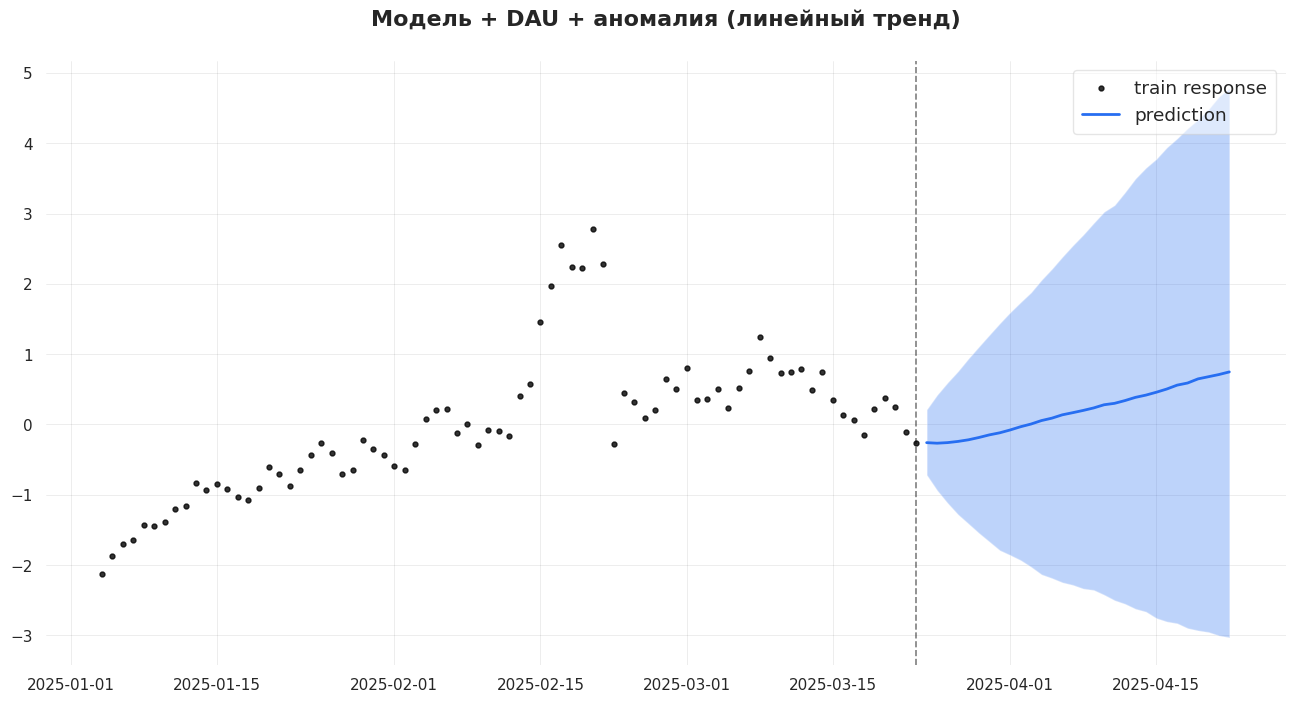

In [32]:
_ = plot_predicted_data(df, pred_5, "date", 'act_stand', title='Модель + DAU + аномалия (линейный тренд)')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

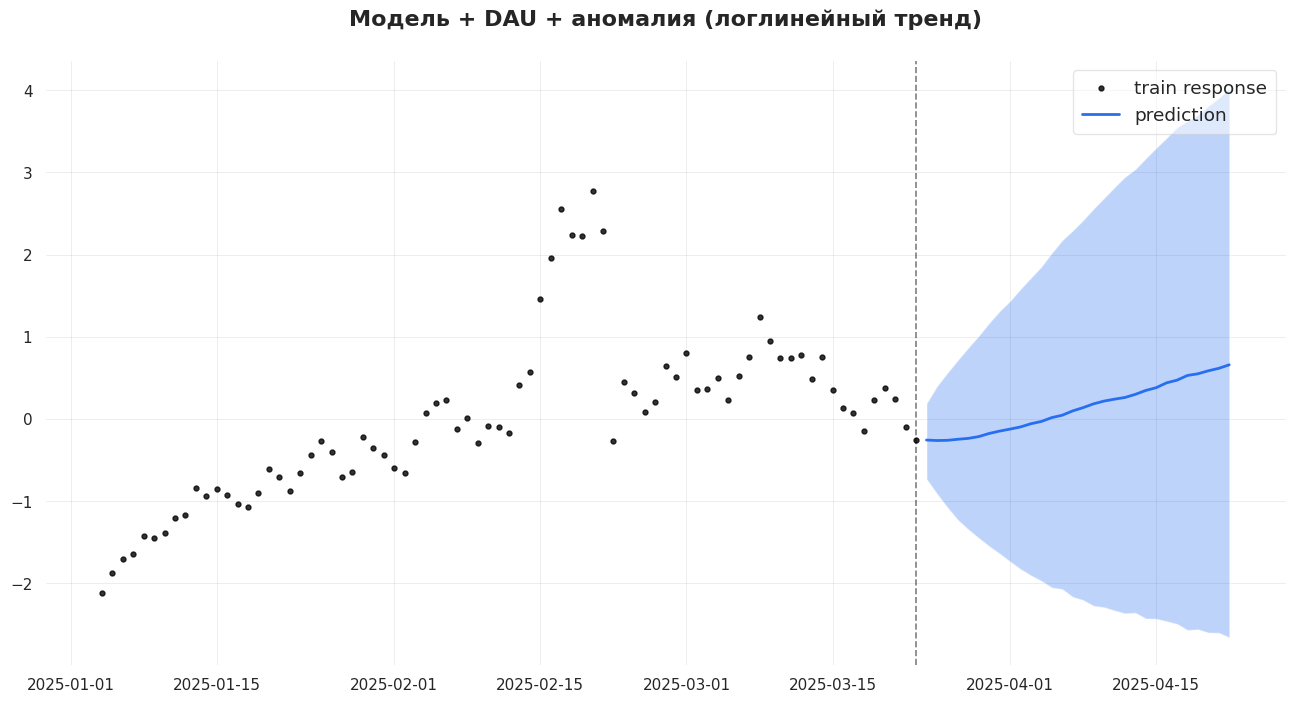

In [33]:
_ = plot_predicted_data(df, pred_6, "date", 'act_stand', title='Модель + DAU + аномалия (логлинейный тренд)')

## Оцениваем качество

In [34]:
#сделаем список для бэктестеров
#начнём со скользящего

test_list_rolling = []

for model in model_list:
    
    backtester = BackTester(
    model=model,
    df=df,
    min_train_len=7,
    incremental_len=7,
    forecast_len=7,
    window_type="rolling")
    
    backtester.fit_predict()
    
    test_list_rolling.append(backtester)

2025-03-23 18:00:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:00:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:01:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:02:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:02:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:02:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:02:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:02:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:02:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:02:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

KeyboardInterrupt: 

In [35]:
test_list_exp = []

for model in model_list:
    
    backtester = BackTester(
    model=model,
    df=df,
    min_train_len=7,
    incremental_len=7,
    forecast_len=7,
    window_type="expanding")
    
    backtester.fit_predict()
    
    test_list_exp.append(backtester)

2025-03-23 18:02:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:02:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:02:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:02:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:02:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:02:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:02:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:02:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:03:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:03:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:03:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:03:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:03:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:03:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:03:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:03:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:03:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:03:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:03:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:04:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:04:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:04:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:04:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:04:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:04:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:04:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:04:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:04:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:04:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:05:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:05:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:05:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:05:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:05:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:05:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:05:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

KeyboardInterrupt: 

In [37]:
roll_df = []

for number, tester in enumerate(test_list_rolling):
    
    inter_df = tester.score()
    inter_df.insert(0, "model_number", number + 1)
    
    roll_df.append(inter_df)
    
roll_df = pd.concat(roll_df)
roll_df = roll_df.set_index("model_number")

In [38]:
roll_df.head()

,metric_name,metric_values,is_training_metric
model_number,,,
1,smape,0.913368,False
1,wmape,1.010383,False
1,mape,2.964672,False
1,mse,1.111957,False
1,mae,0.689217,False


In [39]:
for metric in roll_df.metric_name.unique():
    
    winning_model = roll_df.loc[roll_df.metric_name == metric].metric_values.idxmin()
    
    print(f"Самая лучшая модель по метрике {metric} - {winning_model}")

Самая лучшая модель по метрике smape - 2
Самая лучшая модель по метрике wmape - 2
Самая лучшая модель по метрике mape - 2
Самая лучшая модель по метрике mse - 2
Самая лучшая модель по метрике mae - 2
Самая лучшая модель по метрике rmsse - 2


In [40]:
exp_df = []

for number, tester in enumerate(test_list_exp):
    
    inter_df = tester.score()
    inter_df.insert(0, "model_number", number + 1)
    
    exp_df.append(inter_df)
    
exp_df = pd.concat(exp_df)
exp_df = exp_df.set_index("model_number")

In [41]:
for metric in exp_df.metric_name.unique():
    
    winning_model = exp_df.loc[exp_df.metric_name == metric].metric_values.idxmin()
    
    print(f"Самая лучшая модель по метрике {metric} - {winning_model}")

Самая лучшая модель по метрике smape - 2
Самая лучшая модель по метрике wmape - 2
Самая лучшая модель по метрике mape - 2
Самая лучшая модель по метрике mse - 2
Самая лучшая модель по метрике mae - 2
Самая лучшая модель по метрике rmsse - 2


Итого по результатам бектестинга со скользящим окном и с накопительным эффектом обычная модель с логлинейным трендом является лучшей.


Что по этому поводу скажет WBIC?

In [42]:
for model in model_list:
    
    model.fit_wbic(df)

2025-03-23 18:06:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.369, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:06:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.369, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:06:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.369, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:06:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.369, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:06:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.369, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

2025-03-23 18:07:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 4.369, warmups (per chain): 2500 and samples(per chain): 2500.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [43]:
for number, model in enumerate(model_list):
    
    print(f"Модель №{number+1}, WBIC = {model.get_wbic()}")

Модель №1, WBIC = 70.2806430982672
Модель №2, WBIC = 66.85935792283227
Модель №3, WBIC = 64.16201872308048
Модель №4, WBIC = 61.00948653736237
Модель №5, WBIC = 60.64399945412453
Модель №6, WBIC = 58.06680191765295


Согласно WBIC модель 6 - наиболее качественная 

Таким образом, мы скорее склоняемся к модели №2